In [ ]:
import api_helpers
import pandas as pd

pd.set_option("display.max_columns", None)

/Users/nathanbanks/Projects/mlb/.env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [ ]:
""" Ignore this i'm keeping it for later maybe, just don't want to delete it yet 

hitters_df = pd.DataFrame(hitters).rename(columns=columns_map).dropna(axis=0)

hitters_df[standard_stats] = hitters_df[standard_stats].astype(int)

display(hitters_df[['player', 'team'] + standard_stats + calc_metrics].sort_values('ab', ascending=False))

hitters_df['c_goao'] = round(hitters_df['go'] / hitters_df['ao'], 2)
hitters_df['xbh'] = hitters_df['2b'] + hitters_df['3b'] + hitters_df['hr']
hitters_df['iso'] = round((hitters_df['2b'] + (2*hitters_df['3b']) + (3*hitters_df['hr'])) / hitters_df['ab'], 3)
hitters_df['bb_k'] = round(hitters_df['bb'] / hitters_df['so'], 3)
hitters_df['bb_rate'] = round(hitters_df['bb'] / hitters_df['pa'], 3)
hitters_df['so_rate'] = round(hitters_df['so'] / hitters_df['pa'], 3)

display(hitters_df[['player', 'team'] + expanded_stats + calculated_stats].sort_values('pa', ascending=False))


red_sox_roster_person_stats = api_helpers.call_api(f"/teams/{redsox_team_id}/roster?active=active&hydrate=person(stats(group=[hitting],type=[sabermetrics,seasonAdvanced,season],season=2025))")

hitters = []
for player in red_sox_roster_person_stats['roster']:
    player['team_abbr'] = teams_df.loc[redsox_team_id].abbreviation
    if 'stats' in player['person']:
        hitters.append(get_hitting_stats(player))
"""

# Stats

Want to get a better understanding of most big stats. want to mostly look at distributions, min/max, etc

will need to consider outliers and find where to start leaving people out of the calc. like min plate appearances or IP

the /stats endpoint lets you get hitting fielding and pitching stats pretty easily once you figure it out. more below

fun things to do moving forward:
- more exploration of hitting trends - rbi's, homeruns, literally everything
- calculate avg, slg, obp, ops from api given metrics
- get base metrics from game or play by play data
- look at position, does it change anything?
 


### qualified
MLB stats use a concept called qualified batters (or pitchers, or fielders) that only give scoring titles and records to people that have actually been playing. 

It sets qualified batters as ones that have 3.1x as many Plate Attempts as there have been scheduled games.
- at the time of writing (7/20/25) there are 99-101 games for most teams, so batters would need 310-ish Plate Attempts to qualify.
- there are currently 672 players with hitting data of some kind from this season.
- here are the percentages of original batters we will keep with differen't thresholds of Plate Attempts (given 100 games)
  - 310 : 23.4%
  - 250 : 31.4%
  - 175 : 42.3%
  - 100 : 58.2%
- will need to find one, 310 is for breaking records, not playing with stats. but anyone under 100 plate attempts hasn't done shit, going with 1.75x plate appearances as games for now...

## Stats endpoint

this endpoint is sick. once call gets stats for anyone in the league. the 'stats' param lets you slice the data in different ways, i started with the season one, but you can find more specifics in seasonAdvanced, and even WAR and that kinda stuff in sabermetrics. One i haven't needed yet but thought would be potentially cool is the "lastXGames or byDAteRange ones. then group is pretty simple, that's just where you pick hitting or pitching. the other important-ish thing is the playerPool, it defaults to "QUALIFIED" i'm pretty sure, which only returns batters with 3.1x plate appearances as their team has had games, which takes out like 75% of the players, so switch it to ALL and just be aware there will be a few dudes with 1.000 avgs because they've only batted a few times

### params:

#### required: 
- stats - ['projected', 'projectedRos', 'yearByYear', 'yearByYearAdvanced', 'yearByYearPlayoffs', 'season', 'standard', 'advanced', 'career', 'careerRegularSeason', 'careerAdvanced', 'seasonAdvanced', 'careerStatSplits', 'careerPlayoffs', 'gameLog', 'playLog', 'pitchLog', 'metricLog', 'metricAverages', 'pitchArsenal', 'outsAboveAverage', 'expectedStatistics', 'sabermetrics', 'sprayChart', 'tracking', 'vsPlayer', 'vsPlayerTotal', 'vsPlayer5Y', 'vsTeam', 'vsTeam5Y', 'vsTeamTotal', 'lastXGames', 'byDateRange', 'byDateRangeAdvanced', 'byMonth', 'byMonthPlayoffs', 'byDayOfWeek', 'byDayOfWeekPlayoffs', 'homeAndAway', 'homeAndAwayPlayoffs', 'winLoss', 'winLossPlayoffs', 'rankings', 'rankingsByYear', 'statsSingleSeason', 'statsSingleSeasonAdvanced', 'hotColdZones', 'availableStats', 'opponentsFaced', 'gameTypeStats', 'firstYearStats', 'lastYearStats', 'statSplits', 'statSplitsAdvanced', 'atGameStart', 'vsOpponents', 'sabermetricsMultiTeam']
- group - ['hitting', 'pitching', 'fielding', 'catching', 'running', 'game', 'team', 'streak']

#### optional
- personId
- teamId
- teamIds
- gameType - ex: "REGULAR_SEASON"
- season
- seasons
- sportId
- sportIds
- leagueId
- leagueIds
- leagueListId
- metris (/metrics) but i'm confused cause there's way more on line
- gamePk
- batterTeamId
- pitcherTeamId
- batterId
- pitcherId
- sitCodes - big ass list...
- combineSits - multiple sit codes
- opposingTeamId
- fields - ['standard', 'advanced', 'tracking', 'expected', 'sabermetrics', 'rankings', 'percentiles']
- sortStat
- order - asc, desc
- playerPool - options: All, QUALIFIED, ROOKIES, QUALIFIED_ROOKIES, QUALIFIED_ROOKIES, ORGANIZATION, ORGANIZATION_NO_MLB, CURRENT, ALL_CURRENT, QUALIFIED_CURRENT
- position - (/positions)
- startDate
- endDate
- daysBack
- gamesBack
- excludeTradedPlayers - bool
- offset
- limit

In [54]:
"""
pick values
"""

stat_types = [s['display_name'] for s in api_helpers.call_api('/statTypes')]
stat_groups = [s['display_name'] for s in api_helpers.call_api('/statGroups')]
stat_fields = [s['name'] for s in api_helpers.call_api('/statFields')]

game_types = api_helpers.process_endpoint_url('https://statsapi.mlb.com/api/v1/gameTypes') # list of dicts like this {'id': 'R', 'description': 'Regular Season'}
metrics = api_helpers.process_endpoint_url('https://statsapi.mlb.com/api/v1/metrics')
positions = api_helpers.process_endpoint_url('https://statsapi.mlb.com/api/v1/positions')
situation_codes = api_helpers.process_endpoint_url('https://statsapi.mlb.com/api/v1/situationCodes')
roster_types = api_helpers.call_api("/rosterTypes")

### stat definitions

- Runs Created (RC)

  - basic: ((hits + walks) x total_bases) / (at_bats + walks)

  - stolen base: ((Hits + Walks – Caught Stealing) * (Total Bases + (0.55 * Stolen Bases))) / (At Bats + Walks)

  - technical: ((Hits + Walks – Caught Stealing + Hit by Pitch – Ground into Double Play) * (Total Bases * (0.26 * (Walks – Intentional Walks + Hit by Pitch)) + (0.52 * (Sacrifice Hits + Sacrifice Flies + Stolen Bases)))) / (At Bats + Walks + Hit by Pitch + Sacrifice Hits + Sacrifice Flies)

- Plate Attempts (PA) - Total trips to the plate

- At Bats (AB)
  - Plate Attempts - (walks + sacrifices + hbp + interference)

- Batting Average (AVG)
  - hits / at bats

- On Base Percentage (OBP) - tries to also give credit for when you get on base but don't hit the ball
  - hit + walk + hit by pitch / (at bats + walks + hbp + sacfly)

- Slugging Percentage (SLG) - tries to get more credit to xbh's
  - 1b + (2 * 2b) + (3 * 3b) + (4 * hr)

- On Base Plus Slugging (OPS) - just both of them added together
  - opb + slg

- Extra Base Hits (XBH) - just the count of any doubles, tripples or homeruns
  - 2b + 3b + hr

- batting average on balls in play (BABIP) - removes outcomes NOT affected by opposing defense (HR, K)
  - H - HR / AB - K - HR + sacfly

- rate of extra bases per at bat (ISO) - power metric
  - 2b + 2*3b + 3*hr / ab

In [109]:
teams = api_helpers.get_teams(2025)
teams_df = pd.DataFrame(teams).set_index('id')

def get_team_abbr(row):
    return teams_df.loc[row['team_id'], 'abbreviation'] 

In [ ]:
"""
really think this should be it's own file eventually, it's a bit out of hand
"""

columns_map = {
    'full_name': 'player',
    'hitting_season__games_played': 'gp', # games played
    'hitting_season__at_bats': 'ab', # at bats
    'hitting_season__plate_appearances': 'pa', # plate appearances
    'hitting_season__runs': 'r', # runs
    'hitting_season__hits': 'h', # hits
    'hitting_season__doubles': '2b', # doubles
    'hitting_season__triples': '3b', # triples
    'hitting_season__home_runs': 'hr', # homeruns
    'hitting_season__rbi': 'rbi', # runs batted in
    'hitting_season__total_bases': 'tb', # total bases
    'hitting_season__base_on_balls': 'bb', # walks
    'hitting_season__hit_by_pitch': 'hbp', # hit by pitch
    'hitting_season__strike_outs': 'so', # strikeouts
    'hitting_season__stolen_bases': 'sb', # stolen bases
    'hitting_season__caught_stealing': 'cs', # caught stealing
    'hitting_season__stolen_base_percentage': 'sb_rate',
    
    'hitting_season__avg': 'avg', # batting average
    'hitting_season__obp': 'obp', # on base percentage
    'hitting_season__slg': 'slg', # slugging percentage
    'hitting_season__ops': 'ops', # on base + slugging

    'hitting_season__ground_into_double_play': 'gidp', # ground into double play
    'hitting_season__intentional_walks': 'ibb', # intentional walks
    'hitting_season__ground_outs': 'go', # ground outs
    'hitting_season__air_outs': 'ao', # air outs
    'hitting_season__ground_outs_to_airouts': 'goao',
    'hitting_season__babip': 'babip', # batting average on balls hit in play

    'hitting_season__sac_flies': 'sf',
    'hitting_season__sac_bunts': 'sac',
    'hitting_season__at_bats_per_home_run': 'ab_hr',
}

standard_stats = ['gp','ab','r','h','2b','3b','hr','rbi','bb','so','sb','cs']
calc_metrics = ['sb_rate','avg','obp','slg','ops']
expanded_stats = ['pa','hbp','sac','sf','gidp','goao']
calculated_stats = ['c_goao', 'xbh', 'tb', 'ibb', 'babip', 'iso', 'ab_hr', 'bb_k', 'bb_rate', 'so_rate']

In [59]:
stats_endpoint = "/stats?sportId=1&stats=season,seasonAdvanced&group=hitting&playerPool=ALL"
first_stats_resp = api_helpers.call_api(stats_endpoint)['stats']

players_dict = {}
pages = round(first_stats_resp[0]['total_splits']/50)

for group in first_stats_resp:
    for s in group['splits']:
        stat_dict = {f"{group['group']['display_name']}_{group['type']['display_name']}__{k}": v for k,v in s['stat'].items()}
        if s['player']['id'] not in players_dict:
            stat_dict['player_name'] = s['player']['full_name']
            stat_dict['player_position'] = s['position']['abbreviation']
            stat_dict['player_position_type'] = s['position']['type']
            stat_dict['player_position_code'] = s['position']['code']
            stat_dict['team_id'] = s['team']['id']
            stat_dict['team_name'] = s['team']['name']
            players_dict[s['player']['id']] = stat_dict
        else:
            players_dict[s['player']['id']].update(stat_dict)

for i in range(pages):
    new_page = api_helpers.call_api(f"{stats_endpoint}&offset={50*(i+1)}")['stats']
    for group in new_page:
        for s in group['splits']:
            stat_dict = {f"{group['group']['display_name']}_{group['type']['display_name']}__{k}": v for k,v in s['stat'].items()}
            if s['player']['id'] not in players_dict:
                stat_dict['player_name'] = s['player']['full_name']
                stat_dict['player_position'] = s['position']['abbreviation']
                stat_dict['player_position_type'] = s['position']['type']
                stat_dict['player_position_code'] = s['position']['code']
                stat_dict['team_id'] = s['team']['id']
                stat_dict['team_name'] = s['team']['name']
                players_dict[s['player']['id']] = stat_dict
            else:
                players_dict[s['player']['id']].update(stat_dict)

In [60]:
hitting_stats_df = pd.DataFrame().from_dict(players_dict, orient='Index').rename(columns=columns_map)
hitting_stats_df['team_abbr'] = hitting_stats_df.apply(get_team_abbr, axis=1)

hitting_stats_df[['avg','obp','slg','ops']] = hitting_stats_df[['avg','obp','slg','ops']].astype(float)

hitting_std = hitting_stats_df[['player_name','team_abbr', 'player_position'] + ['pa'] + standard_stats + calc_metrics]

### exploring hitting data

In [100]:
describes = {}
describes['310'] = hitting_std[hitting_std['pa'] >= 310][['avg','obp','slg','ops']].describe()
describes['250'] = hitting_std[hitting_std['pa'] >= 250][['avg','obp','slg','ops']].describe()
describes['175'] = hitting_std[hitting_std['pa'] >= 175][['avg','obp','slg','ops']].describe()
describes['100'] = hitting_std[hitting_std['pa'] >= 100][['avg','obp','slg','ops']].describe()

describes['250'].rename(columns={'avg': '250_avg', 'obp': '250_obp', 'slg': '250_slg', 'ops': '250_ops'})
all_describes = describes['310'].join(describes['250'], lsuffix="_310", rsuffix="_250").join(describes['175'], lsuffix= "", rsuffix="_175").join(describes['100'], rsuffix="_100")
all_describes = all_describes.rename(columns={'avg': 'avg_175', 'obp': 'obp_175', 'slg':'slg_175', 'ops': 'ops_175'})

with pd.option_context('display.precision', 3):
    display(all_describes[['avg_310','avg_250','avg_175','avg_100']])
    display(all_describes[['obp_310','obp_250','obp_175','obp_100']])
    display(all_describes[['slg_310','slg_250','slg_175','slg_100']])
    display(all_describes[['ops_310','ops_250','ops_175','ops_100']])

NameError: name 'hitting_std' is not defined

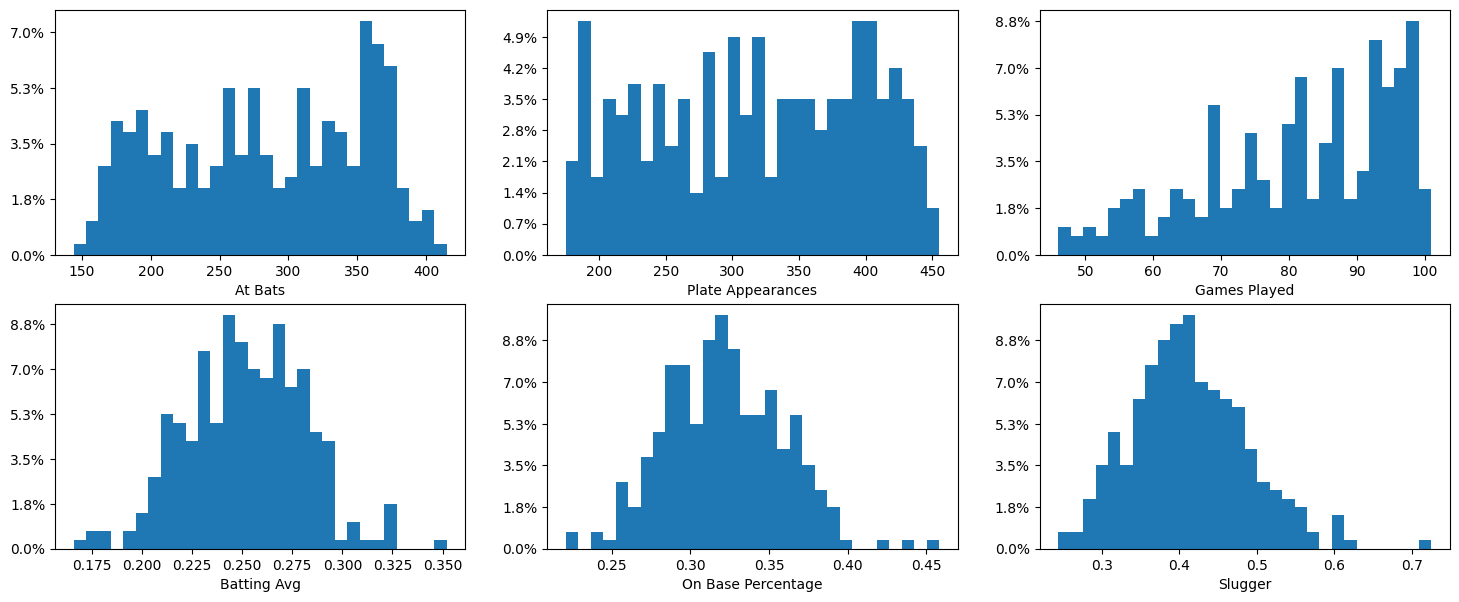

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

graphing_df = hitting_std[hitting_std['pa'] >= 175]

fig, axs = plt.subplots(2,3,figsize=(18,7))

axs[0][0].hist(graphing_df['ab'], bins=30,density=False)
axs[0][0].yaxis.set_major_formatter(PercentFormatter(len(graphing_df)))
axs[0][0].set(xlabel='At Bats')

axs[0][1].hist(graphing_df['pa'], bins=30,density=False)
axs[0][1].yaxis.set_major_formatter(PercentFormatter(len(graphing_df)))
axs[0][1].set(xlabel='Plate Appearances')

axs[0][2].hist(graphing_df['gp'], bins=30,density=False)
axs[0][2].yaxis.set_major_formatter(PercentFormatter(len(graphing_df)))
axs[0][2].set(xlabel='Games Played')

axs[1][0].hist(graphing_df['avg'], bins=30,density=False)
axs[1][0].yaxis.set_major_formatter(PercentFormatter(len(graphing_df)))
axs[1][0].set(xlabel='Batting Avg')

axs[1][1].hist(graphing_df['obp'], bins=30,density=False)
axs[1][1].yaxis.set_major_formatter(PercentFormatter(len(graphing_df)))
axs[1][1].set(xlabel='On Base Percentage')

axs[1][2].hist(graphing_df['slg'], bins=30,density=False)
axs[1][2].yaxis.set_major_formatter(PercentFormatter(len(graphing_df)))
axs[1][2].set(xlabel='Slugger')

plt.show()

### Pitching

lastXGames endpoint: "/stats?sportId=1&stats=lastXGames&group=pitching&gamesBack=8&playerPool=QUALIFIED&offset=0"

In [ ]:
pitching_col_map = {
    'pitching_season__wins': 'w',
    'pitching_season__losses': 'l',
    'pitching_season__era': 'era',
    'pitching_season__games_played': 'g',
    'pitching_season__games_started': 'gs',
    'pitching_season__complete_games': 'cg',
    'pitching_season__shutouts': 'sho',
    'pitching_season__saves': 'sv',
    'pitching_season__save_opportunities': 'svo',

    'pitching_season__innings_pitched': 'ip',
    'pitching_season__hits': 'h',
    'pitching_season__runs': 'r',
    'pitching_season__earned_runs': 'er',
    'pitching_season__home_runs': 'hr',

    'pitching_season__hit_batsmen': 'hb',

    'pitching_season__base_on_balls': 'bb',
    'pitching_season__strike_outs': 'so',
    'pitching_season__whip': 'whip',
    'pitching_season__avg': 'avg', # h / ab
    'pitching_season__at_bats': 'ab',

    'pitching_season__batters_faced': 'tbf',
    'pitching_season__number_of_pitches': 'np',
    'pitching_season__strikes': 'pitching_season__strikes',
    'pitching_season__strike_percentage':'pitching_season__strike_percentage',
    'pitching_season__pitches_per_inning': 'p_ip',
    'pitching_season__games_finished': 'gf',
    'pitching_season__holds': 'hld',
    'pitching_season__intentional_walks': 'ibb',
    'pitching_season__wild_pitches': 'wp',
    'pitching_season__balks': 'bk',
    'pitching_season__ground_into_double_play': 'gdp',
    'pitching_season__ground_outs_to_airouts': 'goao',
    'pitching_season__strikeouts_per9_inn': 'so_9',
    'pitching_season__walks_per9_inn': 'bb_9',
    'pitching_season__strikeout_walk_ratio': 'k_bb',
    'pitching_season__stolen_bases': 'sb',
    'pitching_season__caught_stealing': 'cs',
    'pitching_season__pickoffs': 'pk',
    'pitching_season__stolen_base_percentage': 'pitching_season__stolen_base_percentage',
}

standard = ['w','l','era','g','gs','cg','sho','sv','svo', 'ip','h', 'r','er','hr','hb','bb','so','whip','avg']

In [81]:
def get_pitch_data(data, out_dict):
    for group in data:
        for split in group['splits']:
            p_id = split['player']['id']
            stats_info = {f"{group['group']['display_name']}_{group['type']['display_name']}__{k}": v 
                          for k,v in split['stat'].items()}
            if p_id not in out_dict:
                out_dict[p_id] = {
                    'player': split['player']['full_name'],
                    'team_id': split['team']['id'],
                    'team_name': split['team']['name']
                }
            out_dict[p_id].update(stats_info)

In [111]:
pitching_endpoint = "/stats?sportId=1&stats=season,sabermetrics&group=pitching&playerPool=QUALIFIED"

out_d = {}
offset = 0
total_splits = 1

while offset <= total_splits:
    p = api_helpers.call_api("{}&offset={}".format(pitching_endpoint, offset))['stats']
    get_pitch_data(p, out_d)
    offset += 50
    total_splits = p[0]['total_splits']

pitching_stats = pd.DataFrame().from_dict(out_d, orient='Index').rename(columns=pitching_col_map)
pitching_stats['team'] = pitching_stats.apply(get_team_abbr, axis=1)

In [116]:
pitching_stats['team'] = pitching_stats.apply(get_team_abbr, axis=1)
pitching_stats[['player','team'] + standard].sort_values('so', ascending=False).head(15)

,player,team,w,l,era,g,gs,cg,sho,sv,svo,ip,h,r,er,hr,hb,bb,so,whip,avg
676979,Garrett Crochet,BOS,11,4,2.19,21,21,1,1,0,0,135.1,108,36,33,10,0,36,165,1.06,.216
669373,Tarik Skubal,DET,10,3,2.19,20,20,1,1,0,0,127.2,88,31,31,9,4,16,164,0.81,.192
554430,Zack Wheeler,PHI,9,3,2.36,19,19,1,0,0,0,122.0,79,34,32,13,4,26,154,0.86,.181
686613,Hunter Brown,HOU,9,4,2.57,20,20,1,0,0,0,119.0,82,35,34,12,4,36,144,0.99,.195
669022,MacKenzie Gore,WSH,4,9,3.59,20,20,0,0,0,0,112.2,105,46,45,13,3,38,140,1.27,.247
657277,Logan Webb,SF,9,7,3.08,21,21,0,0,0,0,131.2,130,49,45,9,3,29,140,1.21,.259
656302,Dylan Cease,SD,3,9,4.64,20,20,0,0,0,0,108.2,102,59,56,15,3,39,139,1.30,.245
607074,Carlos Rodón,NYY,10,6,3.08,20,20,0,0,0,0,119.2,79,45,41,15,4,41,135,1.00,.184
657746,Joe Ryan,MIN,10,4,2.63,20,19,0,0,0,0,116.1,82,35,34,13,10,23,132,0.90,.197
592662,Robbie Ray,SF,9,4,2.92,21,21,1,0,0,0,123.1,90,43,40,15,1,49,131,1.13,.202


In [115]:
print(pd.get_option("display.max_columns"))

None
